### We will introduce:
1. **MONAI Getting Started**
    - Transformation
    - Datset
    - Network
    


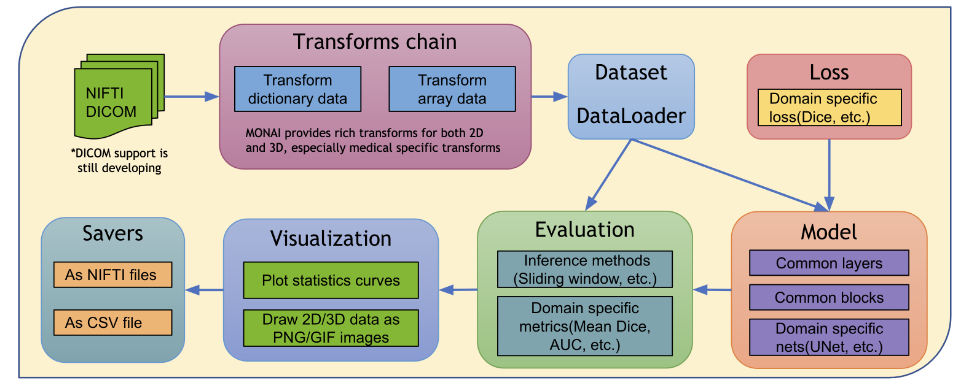

### Reference: <a href="https://github.com/Project-MONAI/MONAIBootcamp2021">MONAI bootcamp 2021</a>

In [2]:
!pip install monai==1.2.0 nibabel

  Using cached monai-1.2.0-202306081546-py3-none-any.whl.metadata (10 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.me

In [3]:
import time
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import monai
import torch

## Creating dummy data
- monai.data.create_test_image_3d

In [ ]:
keys = ["img", "seg"]
filenames = []
root_dir = './data'
!mkdir $root_dir
n_data = 5

for i in range(n_data):
    im, seg = monai.data.create_test_image_3d(256, 256, 256, num_objs=25, rad_max=50)

    im_filename = f"{root_dir}/im{i}.nii.gz"
    seg_filename = f"{root_dir}/seg{i}.nii.gz"
    filenames.append({"img": im_filename, "seg": seg_filename})

    n = nib.Nifti1Image(im, np.eye(4))
    nib.save(n, im_filename)

    n = nib.Nifti1Image(seg, np.eye(4))
    nib.save(n, seg_filename)

In [ ]:
!ls './data'

im0.nii.gz  im2.nii.gz	im4.nii.gz   seg1.nii.gz  seg3.nii.gz
im1.nii.gz  im3.nii.gz	seg0.nii.gz  seg2.nii.gz  seg4.nii.gz


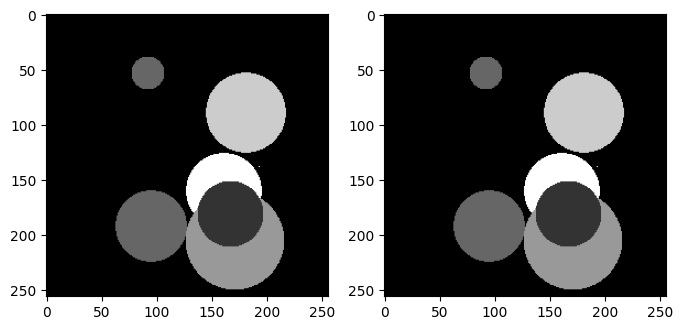

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(im[128], cmap='gray')
plt.subplot(122)
plt.imshow(seg[128], cmap='gray')
plt.show()

In [ ]:
im.min(), im.max(), seg.max()

(0.0, 1.0, 5)

## Transforms
https://docs.monai.io/en/latest/transforms.html
- monai.transforms

"Medical images require highly specialized methods for **I/O, preprocessing, and augmentation**. Medical images are often in specialized formats with rich meta-information, and the data volumes are often high-dimensional. These require carefully designed manipulation procedures. The medical imaging focus of MONAI is enabled by powerful and flexible image transformations that facilitate user-friendly, reproducible, optimized medical data pre-processing pipelines." <a href="https://docs.monai.io/en/latest/highlights.html#medical-image-data-i-o-processing-and-augmentation">Source</a>

In [ ]:
trans = monai.transforms.Compose([monai.transforms.LoadImage(image_only=True), # I/O
                                  monai.transforms.AddChannel(), # Pre-processing
                                  monai.transforms.RandGaussianNoise(prob=0.5, std=0.5), # Augmentation
                                  monai.transforms.ToTensor()]) # Pre-processing

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:111: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. It will be removed in version 1.3. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead with `channel_dim='no_channel'`.
  warn_deprecated(obj, msg, warning_category)


In [ ]:
filenames[0]

{'img': './data/im0.nii.gz', 'seg': './data/seg0.nii.gz'}

<class 'monai.data.meta_tensor.MetaTensor'> torch.Size([1, 256, 256, 256])


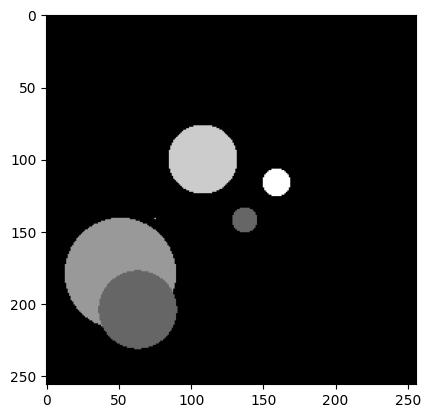

In [ ]:
# Run this cell several times to check the rand term
img = trans(filenames[0]["img"])
print(type(img), img.shape)
plt.imshow(img[0, 128], cmap='gray')

1. Customize transforms: Lambda
    - monai.transforms.Lambda

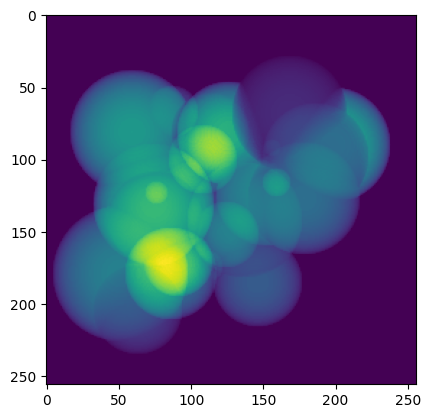

In [ ]:
def sum_width(img):
    return img.sum(1)

trans = monai.transforms.Compose([monai.transforms.LoadImage(image_only=True),
                                  monai.transforms.AddChannel(),
                                  monai.transforms.Lambda(sum_width)])
img = trans(filenames[0]["img"])
plt.imshow(img[0])

2. Customize transforms: inherit

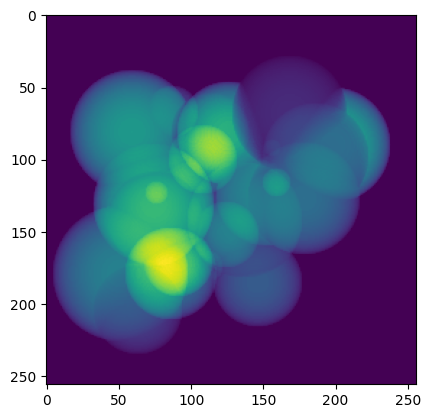

In [ ]:
class SumDimension(monai.transforms.Transform):
    def __init__(self, dim=1):
        self.dim = dim

    def __call__(self, inputs):
        return inputs.sum(self.dim)

trans = monai.transforms.Compose([monai.transforms.LoadImage(image_only=True),
                                  monai.transforms.AddChannel(),
                                  SumDimension()])
img = trans(filenames[0]["img"])
plt.imshow(img[0])

#### Exercise

<class 'monai.data.meta_tensor.MetaTensor'> torch.Size([1, 100, 100, 100])


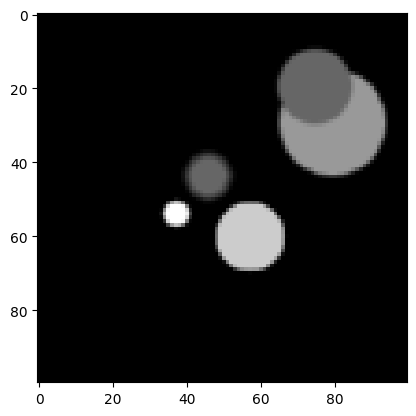

In [ ]:
# Try to implement the transforms below into Compose()
#   -  monai.transforms.Resize, size=(100, 100, 100)
#   -  monai.transforms.RandFlip, prob=0.5

trans = monai.transforms.Compose([monai.transforms.LoadImage(image_only=True),
                                  monai.transforms.AddChannel(),
                                  monai.transforms.Resize((100, 100, 100)),# Resize
                                  monai.transforms.RandFlip(0.5),# RandFlip
                                  monai.transforms.RandGaussianNoise(prob=0.5, std=0.5),
                                  monai.transforms.ToTensor(),])

img = trans(filenames[0]["img"])
print(type(img), img.shape)
plt.imshow(img[0, 50], cmap='gray')

In [ ]:
# Fix the Normalize transform (mean=0, std=1)
class Normalize(monai.transforms.Transform):
    def __init__(self):
        None

    def __call__(self, inputs):
        return (inputs - inputs.mean()) / inputs.std()

trans = monai.transforms.Compose([monai.transforms.LoadImage(image_only=True),
                                  monai.transforms.AddChannel()])

trans_norm = monai.transforms.Compose([monai.transforms.LoadImage(image_only=True),
                                       monai.transforms.AddChannel(),
                                       Normalize()])

img = trans(filenames[0]["img"])
img_norm = trans_norm(filenames[0]["img"])
print('Original mean:', img.mean(), ', std:', img.std())
print('Normalized mean:', img_norm.mean(), ', std:', img_norm.std())

Original mean: metatensor(0.0978) , std: metatensor(0.2521)
Normalized mean: metatensor(1.6618e-08) , std: metatensor(1.)


## Dictionary Transforms
https://docs.monai.io/en/latest/transforms.html#dictionary-transforms

In [ ]:
keys

['img', 'seg']

In [ ]:
# Dictionary version, the input data should be dictionary with keys
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys), # I/O
                                  monai.transforms.AddChanneld(keys), # Pre-processing
                                  monai.transforms.RandGaussianNoised(keys='img', prob=0.5, std=0.5), # Augmentation
                                  monai.transforms.ToTensord(keys)]) # Pre-processing

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:111: FutureWarning: <class 'monai.transforms.utility.dictionary.AddChanneld'>: Class `AddChanneld` has been deprecated since version 0.8. It will be removed in version 1.3. please use MetaTensor data type and monai.transforms.EnsureChannelFirstd instead with `channel_dim='no_channel'`.
  warn_deprecated(obj, msg, warning_category)
/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.transforms.utility.dictionary EnsureChannelFirstd.__init__:meta_keys: Argument `meta_keys` has been deprecated since version 0.9. not needed if ima

In [ ]:
filenames[0]

{'img': './data/im0.nii.gz', 'seg': './data/seg0.nii.gz'}

<class 'dict'> torch.Size([1, 256, 256, 256]) -1


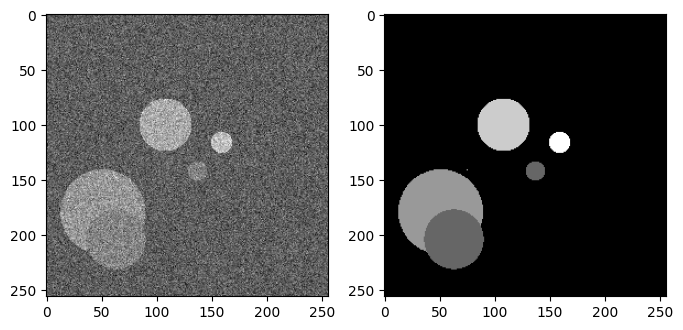

In [ ]:
img_seg = trans(filenames[0])
print(type(img_seg), img_seg['img'].shape, img_seg['img'].get_device())
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(img_seg['img'][0, 128], cmap='gray')
plt.subplot(122)
plt.imshow(img_seg['seg'][0, 128], cmap='gray')

#### Exercise

In [ ]:
# Fix the saveOriginalShaped transform

class SaveOriginalShaped(monai.transforms.MapTransform):
    def __init__(self, img_key, shape_key='ori_shape'):
        self.img_key = img_key
        self.shape_key = shape_key

    def __call__(self, inputs):
        img_data = inputs[self.img_key]
        inputs[self.shape_key] = img_data.shape
        return inputs

trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                                  monai.transforms.AddChanneld(keys),
                                  SaveOriginalShaped('img', 'shape'),
                                  monai.transforms.Resized(keys, spatial_size=(100, 100, 100),),
                                  monai.transforms.ToTensord(keys)])

img_seg = trans(filenames[0])
img_seg['img'].shape, img_seg['shape']

(torch.Size([1, 100, 100, 100]), torch.Size([1, 256, 256, 256]))

## GPU Accelerated Transforms

- Without GPU Accelerated

In [ ]:
trans_list = [monai.transforms.LoadImage(image_only=True),
              monai.transforms.EnsureType(),
              monai.transforms.AddChannel(),
              monai.transforms.ScaleIntensityRange(-1, 1),
              monai.transforms.RandSpatialCrop(roi_size=(192, 192, 192)),
              monai.transforms.Resize([100, 100, 100]),
              monai.transforms.RandFlip(prob=1),
              monai.transforms.RandGaussianNoise(prob=0.5, std=0.5),
              monai.transforms.ToDevice(device='cuda:0'),]
trans = monai.transforms.Compose(trans_list)

n = 20
t1 = time.time()
for i in range(n):
  img = trans(filenames[0]["img"])
t2 = time.time()
print(round((t2-t1)/n, 4))

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.array RandSpatialCrop.__init__:random_size: Current default value of argument `random_size=True` has been deprecated since version 1.1. It will be changed to `random_size=False` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


0.6179


- With GPU Accelerated

In [ ]:
trans_list = [monai.transforms.LoadImage(image_only=True),
              monai.transforms.EnsureType(),
              monai.transforms.ToDevice(device='cuda:0'),
              monai.transforms.AddChannel(),
              monai.transforms.ScaleIntensityRange(-1, 1),
              monai.transforms.RandSpatialCrop(roi_size=(192, 192, 192)),
              monai.transforms.Resize([100, 100, 100]),
              monai.transforms.RandFlip(prob=1),
              monai.transforms.RandGaussianNoise(prob=0.5, std=0.5),]
trans = monai.transforms.Compose(trans_list)

n = 20
t1 = time.time()
for i in range(n):
    img = trans(filenames[0]["img"])
t2 = time.time()
print(round((t2-t1)/n, 4))

0.4887


## Dataset
https://docs.monai.io/en/latest/data.html
- monai.data.Dataset

"Users often need to train the model with many (potentially thousands of) epochs over the data to achieve the desired model quality. A native PyTorch implementation may repeatedly load data and run the same preprocessing steps for every epoch during training, which can be time-consuming and unnecessary, especially when the medical image volumes are large." <a href="https://docs.monai.io/en/latest/highlights.html#datasets-and-dataloader">Source</a>

In [ ]:
items = [{"data": 1},
         {"data": 2},
         {"data": 3},
         {"data": 4},
         {"data": 5},
         {"data": 6},
         {"data": 7}]
dataset = monai.data.Dataset(items, transform=None)

print(f"Length of dataset is {len(dataset)}")
for item in dataset:
    print(item)

Length of dataset is 7
{'data': 1}
{'data': 2}
{'data': 3}
{'data': 4}
{'data': 5}
{'data': 6}
{'data': 7}


In [ ]:
# Compatible with the PyTorch DataLoader
for item in torch.utils.data.DataLoader(dataset, batch_size=2):
    print(item)

{'data': tensor([1, 2])}
{'data': tensor([3, 4])}
{'data': tensor([5, 6])}
{'data': tensor([7])}


### Dataset Caching

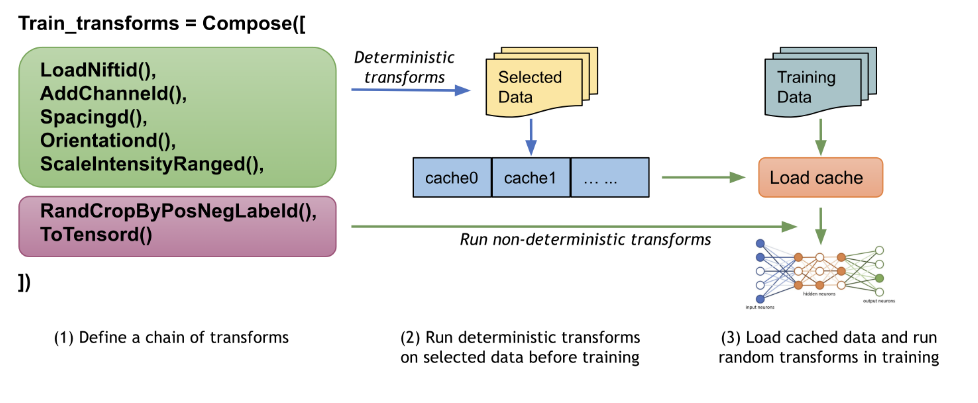

In [ ]:
class SlowSquare(monai.transforms.MapTransform):
    def __init__(self, keys):
        monai.transforms.MapTransform.__init__(self, keys)

    def __call__(self, x):
        time.sleep(1.0) # delay 1 second here
        output = {key: x[key] ** 2 for key in self.keys}
        return output

square_dataset = monai.data.Dataset(items, transform=SlowSquare(keys='data'))

In [ ]:
%time for item in square_dataset: print(item)

{'data': 1}
{'data': 4}
{'data': 9}
{'data': 16}
{'data': 25}
{'data': 36}
{'data': 49}
CPU times: user 34.5 ms, sys: 4.76 ms, total: 39.2 ms
Wall time: 7.01 s


### CacheDataset

In [ ]:
square_cached = monai.data.CacheDataset(items, transform=SlowSquare(keys='data'))

Loading dataset: 100%|██████████| 7/7 [00:07<00:00,  1.00s/it]


In [ ]:
%time for item in square_cached: print(item)

{'data': 1}
{'data': 4}
{'data': 9}
{'data': 16}
{'data': 25}
{'data': 36}
{'data': 49}
CPU times: user 214 µs, sys: 63 µs, total: 277 µs
Wall time: 231 µs


### PersistentDataset

In [ ]:
!rm -r my_cache
square_persist = monai.data.PersistentDataset(items, transform=SlowSquare(keys='data'), cache_dir="my_cache")

In [ ]:
!ls my_cache/

In [ ]:
%time for item in square_persist: print(item)

{'data': 1}
{'data': 4}
{'data': 9}
{'data': 16}
{'data': 25}
{'data': 36}
{'data': 49}
CPU times: user 6.22 ms, sys: 769 µs, total: 6.99 ms
Wall time: 7.75 ms


In [ ]:
!ls my_cache/

In [ ]:
%time for item in square_persist: print(item)

{'data': 1}
{'data': 4}
{'data': 9}
{'data': 16}
{'data': 25}
{'data': 36}
{'data': 49}
CPU times: user 33.8 ms, sys: 11.7 ms, total: 45.5 ms
Wall time: 7.01 s


### Exploration of CacheDataset and GPU Acceleration

- Put the preprocessing transforms in the right position

In [ ]:
## Right
class SlowSquare(monai.transforms.Transform):
    def __init__(self):
        None

    def __call__(self, inputs):
        time.sleep(1.0) # delay 1 second here
        inputs = inputs ** 2
        return inputs

trans_list = [monai.transforms.LoadImage(image_only=True),
              monai.transforms.EnsureType(),
              monai.transforms.AddChannel(),
              monai.transforms.ScaleIntensityRange(-1, 1),
              SlowSquare(),
              monai.transforms.RandSpatialCrop(roi_size=(192, 192, 192)),
              monai.transforms.Resize([100, 100, 100]),
              monai.transforms.RandFlip(prob=1),
              monai.transforms.RandGaussianNoise(prob=0.5, std=0.5),
              monai.transforms.ToDevice(device='cuda:0'),]
trans = monai.transforms.Compose(trans_list)

data = [filenames[0]["img"] for i in range(5)]
cached = monai.data.CacheDataset(data, transform=trans)

n = 2
t1 = time.time()
for i in range(n):
    for i in cached:
        i.shape
t2 = time.time()
print(round((t2-t1)/(n*len(cached)), 4))

Loading dataset: 100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


0.1253


In [ ]:
## Wrong
trans_list = [monai.transforms.LoadImage(image_only=True),
              monai.transforms.EnsureType(),
              monai.transforms.AddChannel(),
              monai.transforms.ScaleIntensityRange(-1, 1),
              monai.transforms.RandSpatialCrop(roi_size=(192, 192, 192)),
              SlowSquare(),
              monai.transforms.Resize([100, 100, 100]),
              monai.transforms.RandFlip(prob=1),
              monai.transforms.RandGaussianNoise(prob=0.5, std=0.5),
              monai.transforms.ToDevice(device='cuda:0'),]
trans = monai.transforms.Compose(trans_list)

data = [filenames[0]["img"] for i in range(5)]
cached = monai.data.CacheDataset(data, transform=trans)

n = 2
t1 = time.time()
for i in range(n):
    for i in cached:
        i.shape
t2 = time.time()
print(round((t2-t1)/n, 4))

Loading dataset: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


5.8997


- GPU Acceleration

In [ ]:
trans_list = [monai.transforms.LoadImage(image_only=True),
              monai.transforms.EnsureType(),
              monai.transforms.ToDevice(device='cuda:0'),
              monai.transforms.AddChannel(),
              monai.transforms.ScaleIntensityRange(-1, 1),
              SlowSquare(),
              monai.transforms.RandSpatialCrop(roi_size=(192, 192, 192)),
              monai.transforms.Resize([100, 100, 100]),
              monai.transforms.RandFlip(prob=1),
              monai.transforms.RandGaussianNoise(prob=0.5, std=0.5),]
trans = monai.transforms.Compose(trans_list)

data = [filenames[0]["img"] for i in range(5)]
cached = monai.data.CacheDataset(data, transform=trans)

n = 20
t1 = time.time()
for i in range(n):
    for i in cached:
        i.shape
t2 = time.time()
print(round((t2-t1)/(n*len(cached)), 4))

Loading dataset: 100%|██████████| 5/5 [00:07<00:00,  1.41s/it]


0.019


## Network
https://docs.monai.io/en/latest/networks.html

#### Built-in network
- https://docs.monai.io/en/latest/networks.html#nets

In [ ]:
net = monai.networks.nets.UNet(
    spatial_dims=3,  # 2 or 3 for a 2D or 3D network
    in_channels=1,  # number of input channels
    out_channels=1,  # number of output channels
    channels=[8, 16],  # channel counts for layers
    strides=[2]  # strides for mid layers
)

In [ ]:
net

UNet(
  (model): Sequential(
    (0): Convolution(
      (conv): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (adn): ADN(
        (N): InstanceNorm3d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (1): SkipConnection(
      (submodule): Convolution(
        (conv): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (adn): ADN(
          (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (D): Dropout(p=0.0, inplace=False)
          (A): PReLU(num_parameters=1)
        )
      )
    )
    (2): Convolution(
      (conv): ConvTranspose3d(24, 1, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(1, 1, 1))
    )
  )
)

In [ ]:
net(torch.ones(2, 1, 24, 24, 24)).shape

torch.Size([2, 1, 24, 24, 24])

## Multi-GPU
- Tutorials: https://github.com/Project-MONAI/tutorials/tree/master/acceleration/distributed_training
- Horovod: https://github.com/horovod/horovod

## Exercise

1. Create a dummy dataset

In [5]:
keys = ["img", "seg"]
filenames = []
root_dir = './data'
!mkdir $root_dir
n_data = 5

for i in range(n_data):
    im, seg = monai.data.create_test_image_3d(256, 256, 256, num_objs=25, rad_max=50)

    im_filename = f"{root_dir}/im{i}.nii.gz"
    seg_filename = f"{root_dir}/seg{i}.nii.gz"
    filenames.append({"img": im_filename, "seg": seg_filename})

    n = nib.Nifti1Image(im, np.eye(4))
    nib.save(n, im_filename)

    n = nib.Nifti1Image(seg, np.eye(4))
    nib.save(n, seg_filename)

mkdir: cannot create directory ‘./data’: File exists


2. Define a GPU accelerated dictionary transformation with `LoadImaged`, `AddChanneld`, `ShiftIntensityd`, `RandSpatialCropd` and `ToTensord`

In [12]:
trans = monai.transforms.Compose([monai.transforms.LoadImaged(keys),
                                  monai.transforms.AddChanneld(keys),
                                  monai.transforms.ShiftIntensityd(keys='img', offset=0.1),
                                  monai.transforms.RandSpatialCropd(keys, roi_size=[128, 128, 128]),
                                  monai.transforms.ToTensord(keys),])

/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)
/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:111: FutureWarning: <class 'monai.transforms.utility.dictionary.AddChanneld'>: Class `AddChanneld` has been deprecated since version 0.8. It will be removed in version 1.3. please use MetaTensor data type and monai.transforms.EnsureChannelFirstd instead with `channel_dim='no_channel'`.
  warn_deprecated(obj, msg, warning_category)
/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.transforms.utility.dictionary EnsureChannelFirstd.__init__:meta_keys: Argument `meta_keys` has been deprecated since version 0.9. not needed if ima

3. Implement `CacheDataset`/`PersistentDataset` with PyTorch DataLoader

In [21]:
data = [filenames[i] for i in range(5)]
dataset = monai.data.CacheDataset(data, transform=trans)

Loading dataset: 100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


4. Define a 3D UNet with 2 times pooling and 3 channels outputs

In [27]:
net = monai.networks.nets.UNet(
    spatial_dims=3,  # 2 or 3 for a 2D or 3D network
    in_channels=1,  # number of input channels
    out_channels=3,  # number of output channels
    channels=[8, 16],  # channel counts for layers
    strides=[2]  # strides for mid layers

)
net

UNet(
  (model): Sequential(
    (0): Convolution(
      (conv): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (adn): ADN(
        (N): InstanceNorm3d(8, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (1): SkipConnection(
      (submodule): Convolution(
        (conv): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (adn): ADN(
          (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (D): Dropout(p=0.0, inplace=False)
          (A): PReLU(num_parameters=1)
        )
      )
    )
    (2): Convolution(
      (conv): ConvTranspose3d(24, 3, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(1, 1, 1))
    )
  )
)

5. Feed the data generated by DataLoader to the UNet

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


ValueError: training mode is expected to be boolean